# Football Expected Goals (xG) Predictor 
*A logistic regression model to quantify shot quality*

**Author:** Charles Salami | **GitHub:** [ChrlyByy](https://github.com/ChrlyByy)  
**Tools:** Python, Pandas, Scikit-learn, Matplotlib  

## Project Overview
Expected Goals (xG) measures the probability of a shot becoming a goal. This project builds a predictive model using shot location and context, following the full data science pipeline.

In [1]:
# !pip install pandas numpy matplotlib seaborn mplsoccer scikit-learn

## Environment Setup & Data Loading

In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')  # Hides ALL warnings
# Loading the dataset, obtained from StatsBomb open data repository
df = pd.read_csv('xg_model.csv')

## Exploratory Data Analysis and Cleaning 

In [3]:
# Lets see the first few rows of the dataframe to understand the structure.
df.head()

,x,y,is_goal,period,Assisted,Zone,IndividualPlay,RegularPlay,LeftFoot,RightFoot,...,Volley,FastBreak,ThrowinSetPiece,Penalty,OneOnOne,KeyPass,DirectFreekick,OwnGoal,OtherBodyPart,DirectCorner
0,80.8,51.6,False,SecondHalf,True,Center,True,True,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,79.3,24.2,False,SecondHalf,True,Center,True,True,NaN,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,80.0,59.5,False,SecondHalf,True,Center,NaN,NaN,NaN,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,89.8,55.6,False,SecondHalf,True,Center,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,84.9,56.2,False,SecondHalf,True,Center,NaN,True,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Let's look at the shape of our dataframe to see how many rows and columns it has.
df.shape

(8118, 25)

In [5]:
# The main column we aere interested in is 'is_goal' which indicates whether a shot resulted in a goal (1) or not (0).
# We use this as our target variable for the xG model.
df.columns

Index(['x', 'y', 'is_goal', 'period', 'Assisted', 'Zone', 'IndividualPlay',
       'RegularPlay', 'LeftFoot', 'RightFoot', 'FromCorner', 'FirstTouch',
       'Head', 'BigChance', 'SetPiece', 'Volley', 'FastBreak',
       'ThrowinSetPiece', 'Penalty', 'OneOnOne', 'KeyPass', 'DirectFreekick',
       'OwnGoal', 'OtherBodyPart', 'DirectCorner'],
      dtype='object')

In [6]:
# Dropping some columns that are not needed for the xG model
# In this case, we drop 'DirectFreekick' and 'DirectCorner' columns because they are not relevant to our analysis. 
# They indicate set-piece situations rather than open play shots.
df.drop({'DirectFreekick','DirectCorner'}, axis=1, inplace=True)


In [7]:
# Let's check the distribution of own goals in the dataset.
df.OwnGoal.value_counts()

OwnGoal
True    27
Name: count, dtype: int64

In [8]:
df[df.OwnGoal == True]

,x,y,is_goal,period,Assisted,Zone,IndividualPlay,RegularPlay,LeftFoot,RightFoot,...,BigChance,SetPiece,Volley,FastBreak,ThrowinSetPiece,Penalty,OneOnOne,KeyPass,OwnGoal,OtherBodyPart
619,5.5,44.0,True,FirstHalf,NaN,Center,NaN,NaN,NaN,NaN,...,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN
749,3.5,51.4,True,FirstHalf,NaN,Center,NaN,NaN,True,NaN,...,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,True,NaN
1382,0.8,51.8,True,SecondHalf,NaN,Center,NaN,NaN,True,NaN,...,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN
1445,3.1,41.5,True,SecondHalf,NaN,Center,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN
1450,4.5,53.1,True,SecondHalf,NaN,Center,NaN,True,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN
2259,1.4,47.9,True,SecondHalf,NaN,Center,NaN,True,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True
2322,2.7,53.6,True,FirstHalf,NaN,Center,NaN,NaN,NaN,True,...,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN
2329,3.9,48.4,True,FirstHalf,NaN,Center,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,True,True
2739,4.5,49.3,True,FirstHalf,NaN,Center,NaN,NaN,NaN,True,...,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN
2895,7.1,48.1,True,SecondHalf,NaN,Center,NaN,True,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN


In [9]:
# Let's drop the own goals from our data
# All shots recorded as 'Own Goal' were filtered out from the dataset. 
# This is crucial because xG is designed to measure the quality of *attacking shots*, not defensive errors. 
# Including own goals would introduce noise and bias the model towards locations where defensive mistakes occur rather than genuine scoring opportunities.
df = df[df['OwnGoal'] != True]
df.drop('OwnGoal', axis=1, inplace=True)

In [10]:
# Shape of the cleaned dataset
df.shape

(8091, 22)

In [11]:
# Checking the distribution of our target variable 'is_goal'
df.is_goal.value_counts()

is_goal
False    7097
True      994
Name: count, dtype: int64

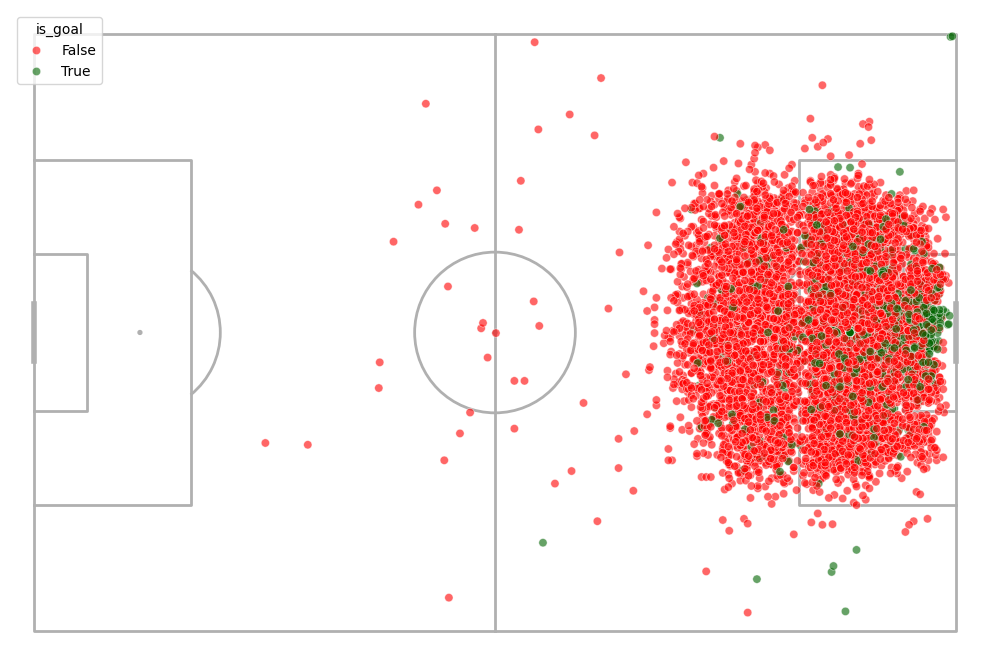

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from mplsoccer import Pitch

# Visualising the shot locations colored by whether they were goals or not
pitch = Pitch(pitch_type='opta')
fig, ax = pitch.draw(figsize=(10, 8))
sns.scatterplot(data=df, x='x', y='y', hue='is_goal', alpha=0.6, palette={False: 'red', True: 'darkgreen'}, ax=ax)
plt.show()


In [ ]:
# Check for missing values 
df.isna().sum()

x                     0
y                     0
is_goal               0
period                0
Assisted           2053
Zone                  0
IndividualPlay     5289
RegularPlay        2714
LeftFoot           5307
RightFoot          4106
FromCorner         6903
FirstTouch         4166
Head               6793
BigChance          6484
SetPiece           7704
Volley             7281
FastBreak          7476
ThrowinSetPiece    7904
Penalty            7985
OneOnOne           7890
KeyPass            8033
OtherBodyPart      8067
dtype: int64

In [ ]:
# Let's fill all of the NaN/empty cell values with 0. 
df.fillna(0, inplace=True)


In [ ]:
# Checking the data types of each column
df.dtypes

x                  float64
y                  float64
is_goal               bool
period              object
Assisted            object
Zone                object
IndividualPlay      object
RegularPlay         object
LeftFoot            object
RightFoot           object
FromCorner          object
FirstTouch          object
Head                object
BigChance           object
SetPiece            object
Volley              object
FastBreak           object
ThrowinSetPiece     object
Penalty             object
OneOnOne            object
KeyPass             object
OtherBodyPart       object
dtype: object

In [ ]:
# Here, we convert the relevant columns to appropriate data types for better memory efficiency and model performance.
df = df.astype({
    'x': float,
    'y': float,
    'is_goal': bool,
    'period': str,
    'Assisted': bool,
    'Zone': str,
    'IndividualPlay':bool,
    'RegularPlay':bool,
    'LeftFoot':bool,
    'RightFoot':bool,
    'FromCorner':bool,
    'FirstTouch':bool, 
    'Head':bool,
    'BigChance': bool,
    'SetPiece': bool,
    'Volley': bool,
    'FastBreak':bool,
    'ThrowinSetPiece':bool,
    'Penalty':bool, 
    'OneOnOne':bool,
    'KeyPass': bool,
    'OtherBodyPart': bool
})


In [ ]:
# Verify the data types after conversion
df.dtypes

x                  float64
y                  float64
is_goal               bool
period              object
Assisted              bool
Zone                object
IndividualPlay        bool
RegularPlay           bool
LeftFoot              bool
RightFoot             bool
FromCorner            bool
FirstTouch            bool
Head                  bool
BigChance             bool
SetPiece              bool
Volley                bool
FastBreak             bool
ThrowinSetPiece       bool
Penalty               bool
OneOnOne              bool
KeyPass               bool
OtherBodyPart         bool
dtype: object

## Data Processing & Feature Engineering
We introduce a couple of features to help our model.
1. Shot distance  
2. Categorical endcoding

In [ ]:
goal_x, goal_y = 100, 50

# Shot distance - Using Euclidean distance from the goal
df["shot_distance"] = np.sqrt((df['x'] - goal_x)**2 + (df['y'] - goal_y)**2)

In [ ]:
df.shot_distance 

0       19.266551
1       33.077636
2       22.141590
3       11.636151
4       16.323296
          ...    
8113    20.999048
8114     7.665507
8115    16.697305
8116    10.572133
8117    15.686937
Name: shot_distance, Length: 8091, dtype: float64

In [ ]:
df["shot_distance"].describe()

count    8091.000000
mean       18.495064
std         8.011289
min         1.581139
25%        12.061300
50%        18.380696
75%        24.200207
max        77.150891
Name: shot_distance, dtype: float64

<Axes: >

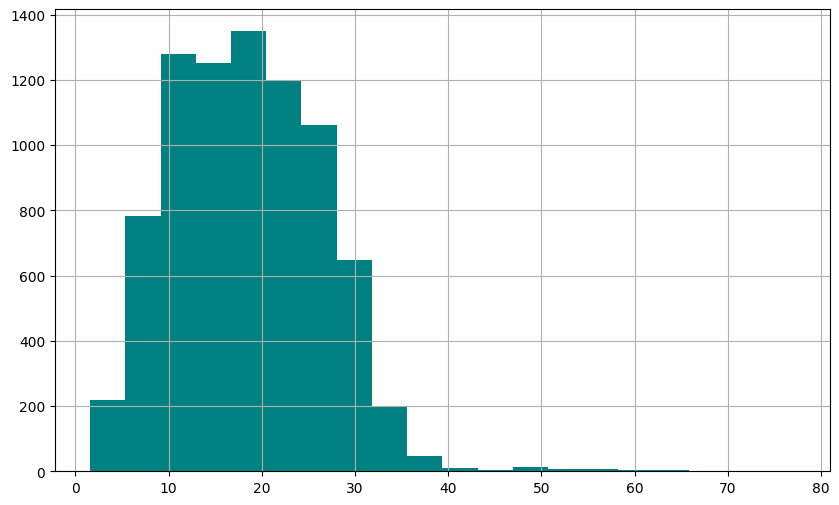

In [ ]:
# Visualising the distribution of shot distances
df.shot_distance.hist(bins=20, color='teal', figsize=(10,6))

In [ ]:
# Goals that were scored either in the first or second half of the match
df.period.value_counts()

period
SecondHalf    4333
FirstHalf     3758
Name: count, dtype: int64

In [ ]:
# Here, we convert categorical variables into numerical format using one-hot encoding.
df = pd.get_dummies(df, columns=['period', 'Zone'])

In [ ]:
df.columns

Index(['x', 'y', 'is_goal', 'Assisted', 'IndividualPlay', 'RegularPlay',
       'LeftFoot', 'RightFoot', 'FromCorner', 'FirstTouch', 'Head',
       'BigChance', 'SetPiece', 'Volley', 'FastBreak', 'ThrowinSetPiece',
       'Penalty', 'OneOnOne', 'KeyPass', 'OtherBodyPart', 'shot_distance',
       'period_FirstHalf', 'period_SecondHalf', 'Zone_Back', 'Zone_Center',
       'Zone_Left', 'Zone_Right'],
      dtype='object')

In [ ]:
# Count of shots in the first half
df.period_FirstHalf.value_counts()

period_FirstHalf
False    4333
True     3758
Name: count, dtype: int64

In [ ]:
# Count of shots in the second half
# Note that we have made two new columns 'period_FirstHalf' and 'period_SecondHalf' after one-hot encoding.
# They both are now boolean columns indicating whether a shot was taken in the respective half.
df.period_SecondHalf.value_counts()

period_SecondHalf
True     4333
False    3758
Name: count, dtype: int64

##  Model Training & Evaluation

In [ ]:
X = df.drop('is_goal', axis=1)
y = df['is_goal']

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score, brier_score_loss

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=67)

In [ ]:
model = LogisticRegression(max_iter=1000)

In [ ]:
model.fit(X_train, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [ ]:
# Predict probabilities on the test set
y_pred_proba = model.predict_proba(X_test)[:, 1]

In [ ]:
# These are the probabilities of a goal for the first 10 shots in the test set
y_pred_proba[0:10]

array([0.07244193, 0.35457963, 0.03723623, 0.03705532, 0.09828467,
       0.0384731 , 0.03410936, 0.04867988, 0.04586231, 0.03959873])

In [ ]:
# Attaching these probabilities to our test data
final_df = X_test.copy()
final_df['goal_probability'] = y_pred_proba

In [ ]:
# Looking at the predicted goal probability for a specific shot
final_df.iloc[419]

x                        87.7
y                        69.3
Assisted                 True
IndividualPlay           True
RegularPlay             False
LeftFoot                 True
RightFoot               False
FromCorner              False
FirstTouch              False
Head                    False
BigChance               False
SetPiece                False
Volley                  False
FastBreak                True
ThrowinSetPiece         False
Penalty                 False
OneOnOne                False
KeyPass                 False
OtherBodyPart           False
shot_distance        22.88624
period_FirstHalf         True
period_SecondHalf       False
Zone_Back               False
Zone_Center              True
Zone_Left               False
Zone_Right              False
goal_probability     0.061969
Name: 4996, dtype: object

In [ ]:
# Show the shots with the highest predicted goal probabilities
# Notice how all shots with the highest xG are penalties, which is expected.
# All penalties have a high likelihood of resulting in a goal, which is accurately reflected in the model's predictions.
# Note that penalties are taken from a very close distance to the goal at the same spot x = 88.5 y = 50.   

final_df.sort_values(by='goal_probability', ascending=False).head()

,x,y,Assisted,IndividualPlay,RegularPlay,LeftFoot,RightFoot,FromCorner,FirstTouch,Head,...,KeyPass,OtherBodyPart,shot_distance,period_FirstHalf,period_SecondHalf,Zone_Back,Zone_Center,Zone_Left,Zone_Right,goal_probability
3671,88.5,50.0,False,False,False,True,False,False,False,False,...,False,False,11.5,False,True,False,True,False,False,0.844188
6619,88.5,50.0,False,False,False,True,False,False,False,False,...,False,False,11.5,False,True,False,True,False,False,0.844188
381,88.5,50.0,False,False,False,True,False,False,False,False,...,False,False,11.5,False,True,False,True,False,False,0.844188
1323,88.5,50.0,False,False,False,True,False,False,False,False,...,False,False,11.5,False,True,False,True,False,False,0.844188
7387,88.5,50.0,False,False,False,False,True,False,False,False,...,False,False,11.5,False,True,False,True,False,False,0.840096


In [ ]:
# Evaluate the model
logloss = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
brier_score = brier_score_loss(y_test, y_pred_proba)

print(f"Log Loss: {logloss}") # Lower is better. To improve the model, we aim to minimize this value.
print(f"ROC AUC: {roc_auc}") # Higher is better. To improve the model, we aim to maximize this value.
print(f"Brier Score: {brier_score}") # Lower is better. To improve the model, we aim to minimize this value.


Log Loss: 0.26940622672081826
ROC AUC: 0.8105173458566884
Brier Score: 0.07725600206308753


## Evaluation Metrics for Probability Models
This xG model outputs probabilities, not binary predictions, so standard accuracy is misleading. We use three specialized metrics:

Log Loss: Measures the quality of the probability estimates themselves, heavily penalizing confident wrong predictions (e.g., a high xG for a miss). A lower score is better, with a perfect model scoring 0.0.

ROC-AUC: Evaluates the model's ability to rank shots. A score of 0.8 means there's an 80% chance that a randomly selected goal was given a higher xG than a randomly selected non-goal. 0.5 is random guessing.

Brier Score: Assesses the calibration of the probabilities—how close the predicted xG is to the real-world frequency. It is the mean squared error of the predictions, where 0.0 is perfect.

Together, a low Log Loss and Brier Score with a high ROC-AUC indicate a model that provides accurate, well-calibrated probabilities that correctly distinguish goals from non-goals.

In [ ]:
from mplsoccer import Pitch
pitch = Pitch(pitch_type='opta')

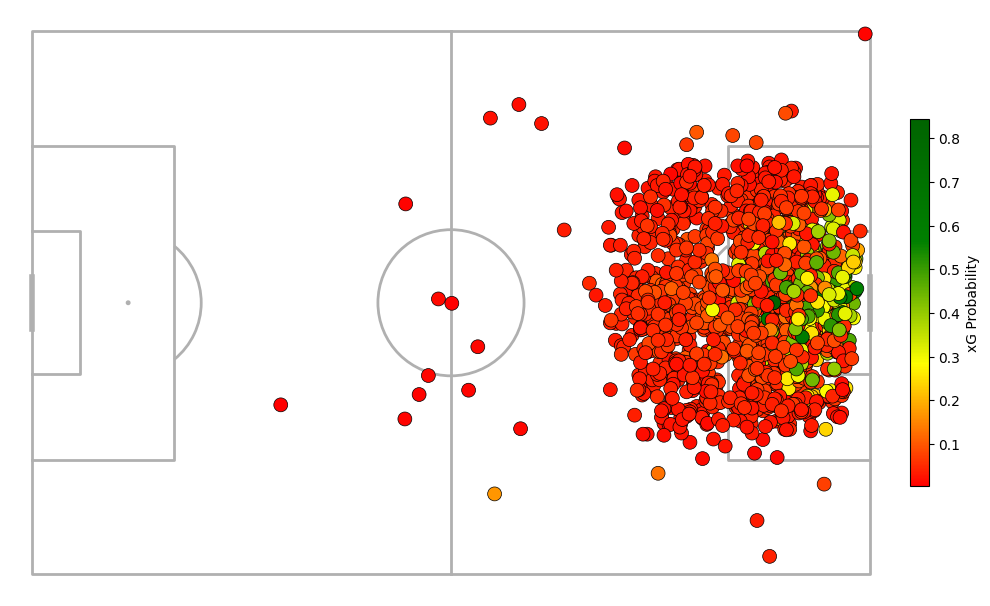

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

# Define the colors for the gradient
colors = ['red', 'yellow', 'green', 'darkgreen']

# Create the custom colormap
cmap = LinearSegmentedColormap.from_list('my_colormap', colors)

fig, ax = pitch.draw(figsize=(10, 8))

# Scatter plot for shots with xG as the color
sc = pitch.scatter(
    final_df['x'], 
    final_df['y'],  # Shot coordinates
    c=final_df['goal_probability'],  # xG probabilities for color
    cmap=cmap,  # Red to green gradient
    edgecolors='black', linewidth=0.5, s=100,  # Point styling
    ax=ax
)

# Add a colour bar to indicate xG values
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', fraction=0.02, pad=0.02)
cbar.set_label('xG Probability')

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score, classification_report

lr = LogisticRegression()

# Define the hyperparameters to search
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', None],  # Type of regularization
    'C': [0.01, 0.1, 1, 10, 100],                  # Regularization strength (smaller = stronger regularization)
    'solver': ['liblinear', 'saga'],               # Solver for optimization
    'max_iter': [100, 500, 1000]                   # Maximum number of iterations
}

# Define the scoring metric
scorer = make_scorer(roc_auc_score, needs_proba=True)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=scorer,
    cv=3,               # 3-fold cross-validation
    verbose=1,
    n_jobs=-1
)          # Use all processors for parallelism

# Fit the model
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarnin

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",LogisticRegre...max_iter=1000)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'C': [0.01, 0.1, ...], 'max_iter': [100, 500, ...], 'penalty': ['l1', 'l2', ...], 'solver': ['liblinear', 'saga']}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",make_scorer(r...ds_proba=True)
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",3
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each 

In [ ]:
# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best ROC AUC Score:", best_score)

# Use the best model to make predictions
best_model = grid_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Evaluate the model on the test set
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test ROC AUC Score: {roc_auc:.4f}")

# Print classification report
y_pred = (y_pred_proba > 0.5).astype(int)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Best Parameters: {'C': 0.01, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best ROC AUC Score: nan
Test ROC AUC Score: 0.7920

Classification Report:
              precision    recall  f1-score   support

       False       0.89      1.00      0.94      1435
        True       0.00      0.00      0.00       184

    accuracy                           0.89      1619
   macro avg       0.44      0.50      0.47      1619
weighted avg       0.79      0.89      0.83      1619



In [ ]:
model = LogisticRegression(C=100, max_iter=100, penalty='l1', solver='liblinear')

model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_test)[:, 1]

logloss = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
brier_score = brier_score_loss(y_test, y_pred_proba)

print(f"Log Loss: {logloss}")
print(f"ROC AUC: {roc_auc}")
print(f"Brier Score: {brier_score}")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


Log Loss: 0.2697890715624492
ROC AUC: 0.812278442660203
Brier Score: 0.07746641579631852
